# Pytorch Tutorial
Working with data, creating models, optimizing model parameters, and saving the trained models

#### Importing libraries

In [2]:
# Working with data
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [23]:
import matplotlib.pyplot as plt

In [3]:
# Tensors
import torch
import numpy as np

## Quickstart

### Working with data
torch.utils.data.DataLoader and torch.utils.data.Dataset
Dataset stores the samples and corresponding labels, DataLoader wraps an iterable around Dataset.

Pytorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets.

Torchvision.datasets

In [2]:
# Download training data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



We pass Dataset as an argument to DataLoader.
This wraps an iterable over the dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading.
Here we define a batch size of 64 - each element in the dataloader iterable will return a batch of 64 features and labels.

In [3]:
batch_size = 64

# create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X[N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}{y.dtype}")
    break

Shape of X[N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64])torch.int64


### Creating models
To define a nn in PyTorch, we create a class that inherits from nn.Module.
We define the layers of the network in __init__ function, and specify how data will pass through the network in the forward function.

In [5]:
# Get cpu/gpu for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Optimize model parametrs
To train a model, we need a loss function and an optimizer

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the trainign dataset (fed to it in batches), and backpropagates the prediction error to adjest the model's parameters

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch  % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}[{current:>5d}|{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuraxy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The trainign process is conducted over several iterations (epochs). During each epoch, the model leans parameters to make better prediction. We print accuracy change with each epoch.

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.317179[   64|60000]
loss: 2.300580[ 6464|60000]
loss: 2.276749[12864|60000]
loss: 2.266305[19264|60000]
loss: 2.268577[25664|60000]
loss: 2.232506[32064|60000]
loss: 2.241753[38464|60000]
loss: 2.216914[44864|60000]
loss: 2.207024[51264|60000]
loss: 2.170359[57664|60000]
Test Error: 
 Accuraxy: 42.0%, Avg loss: 2.171621 

Epoch 2
-------------------------------
loss: 2.187252[   64|60000]
loss: 2.177525[ 6464|60000]
loss: 2.119441[12864|60000]
loss: 2.129583[19264|60000]
loss: 2.108339[25664|60000]
loss: 2.036381[32064|60000]
loss: 2.069111[38464|60000]
loss: 2.003845[44864|60000]
loss: 1.999834[51264|60000]
loss: 1.926460[57664|60000]
Test Error: 
 Accuraxy: 57.7%, Avg loss: 1.931031 

Epoch 3
-------------------------------
loss: 1.969463[   64|60000]
loss: 1.941880[ 6464|60000]
loss: 1.828668[12864|60000]
loss: 1.855707[19264|60000]
loss: 1.783568[25664|60000]
loss: 1.712988[32064|60000]
loss: 1.735969[38464|60000]
loss: 1.646079[44864

### Saving models
A common way to save a model is to serialize the internal state dictioonary (containing the model parameters)

In [11]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### Loading models
Recreating the model structure and loading the state dictionary into it

In [12]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

# This model can now be used to make predictions

<All keys matched successfully>

In [13]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## Tensors

### Initializing tensors

In [19]:
# Directly from data
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)

# From numpy array
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

# From another tensor (the properties can be kept or changed)
x_ones = torch.ones_like(x_data)
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

# With random constant values
shape = (2, 3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.9043, 0.1296],
        [0.1840, 0.6393]]) 

Random Tensor: 
 tensor([[0.8342, 0.5718, 0.5698],
        [0.6155, 0.7258, 0.2596]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


### Attributes of a tensor

In [20]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


### Operations on Tensors

#### Moving tensor to GPU

In [21]:
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

#### Standard numpy-like indexing and slicing

In [5]:
tensor = torch.ones(4, 4)
print(tensor)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


#### Joining tensors
With torch.cat or torch.stack

In [24]:
t1 = torch.cat([tensor, tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


#### Arithmatic operations

In [33]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)
y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)

print(y1,"\n\n", y2, "\n\n", y3)

# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)
z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)
print("\n\n", z1,"\n\n", z2, "\n\n", z3)


tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]]) 

 tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]]) 

 tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])


 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

 tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


#### Single element tensor
If you have a one-element tensor, for example by aggregating all values of a tensor into one value, you can convert it to a Python numerical value using item():

In [34]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


#### In-place operations:
Operations that store the result into the operand are called in-place. They are denoted by a _ suffix. For example: x.copy_(y), x.t_(), will change x.

In [6]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


#### Bridge with numpy
Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other.

In [18]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

# a change in one will change other
t.add_(1)
print()
print(f"t: {t}")
print(f"n: {n}")

# NumPy array to tensor
n = np.ones(5)
t = torch.from_numpy(n)
print()
print(t)

# Changes in the numpy array reflects in the tensor
np.add(n, 1, out=n)
print()
print(f"t: {t}")
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]

tensor([1., 1., 1., 1., 1.], dtype=torch.float64)

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


## Datasets and dataloaders
Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code
to be decoupled from our model training code for better readability and modularity.
PyTorch provides two data primitives: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``
that allow you to use pre-loaded datasets as well as your own data.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset`` to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that
subclass ``torch.utils.data.Dataset`` and implement functions specific to the particular data.
They can be used to prototype and benchmark your model. You can find them
here: [Image Datasets](https://pytorch.org/vision/stable/datasets.html),
[Text Datasets](https://pytorch.org/text/stable/datasets.html), and
[Audio Datasets](https://pytorch.org/audio/stable/datasets.html)

#### Loading datasets
Here is an example of how to load the [Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/) dataset from TorchVision.
Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples.
Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

We load the [FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) with the following parameters:
 - ``root`` is the path where the train/test data is stored,
 - ``train`` specifies training or test dataset,
 - ``download=True`` downloads the data from the internet if it's not available at ``root``.
 - ``transform`` and ``target_transform`` specify the feature and label transformations

In [19]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

#### Iterating and visualizing the dataset
We can index ``Datasets`` manually like a list: ``training_data[index]``.
We use ``matplotlib`` to visualize some samples in our training data.

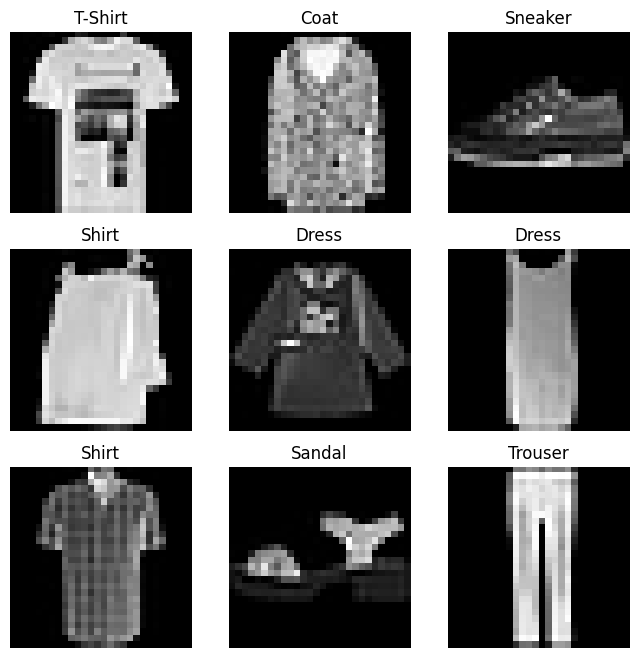

In [24]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Creating a custom dataset for your files
A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`.
Take a look at this implementation; the FashionMNIST images are stored
in a directory ``img_dir``, and their labels are stored separately in a CSV file ``annotations_file``.

In the next sections, we'll break down what's happening in each of these functions.

In [28]:
import os
import pandas as pd
from torchvision.io import read_image

ModuleNotFoundError: No module named 'pandas'

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label